<a href="https://colab.research.google.com/github/duydung271/MachineLearning/blob/main/Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##How to save and load an object with Pickle in Python

Cách này chỉ lưu data của một Object. Nên khi dùng phải copy code phần class vào.

Create an Object Class

In [ ]:
class Machine:
  def __init__(self, W):
    self.W = W 
  def fit(X, Y):
    print("trained");
  def predict(X):
    print("answer");

model = Machine([0.1,0.1])

Save this Object Class

In [ ]:
import pickle
f = open("/content/drive/MyDrive/Colab Notebooks/Data/ModelMachine.pickle", "wb")
pickle.dump(model, f)
f.close()

Load Object

In [ ]:
import pickle
f = open("/content/drive/MyDrive/Colab Notebooks/Data/ModelMachine.pickle", "rb")
loaded_model = pickle.load(f)
f.close()
print(loaded_model.W)

[0.1, 0.1]


##Preprocess Data Training

Lấy image_links và tạo labels

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
9476


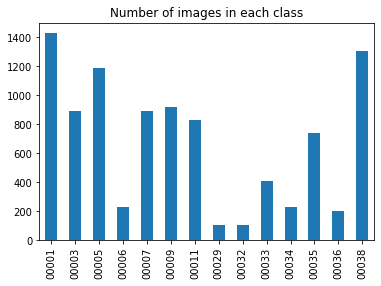

In [4]:
from google.colab import drive
import os

drive.mount("/content/drive")
path = '/content/drive/MyDrive/Colab Notebooks/Data/Train_Data_Challenge_1'
os.chdir(path)
os.listdir()

import pandas as pd
import glob2
import matplotlib.pyplot as plt
set_of_labels = os.listdir(path+'/Train')

labels=[]
image_links=[]
for i in range(0,len(set_of_labels)):
  datas = glob2.glob('Train/'+set_of_labels[i]+'/*.jpg')
  data_labels= [set_of_labels[i]]*len(datas)
  labels = labels + data_labels
  image_links = image_links + datas

data = pd.DataFrame({'labels': labels, 'image_links':image_links})

print(len(labels))

data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()


**Dataset**

Dùng thư viện có sẵn `train_test_split` để chia tập `data train` và `data validation`.

Một số **paramester** của hàm:

- `test_size`: float or int, defaul=None
  - Nếu là float: Nó sẽ nằm trong khoảng giữa 0.0 và 1.0 đại điện cho số phần sẽ lấy trong dataset.
  - Nếu là int: thì sẽ lấy một số lượng test cố định luôn.
  - None: value sẽ tự động set là 0.25.

- `train_size`: float or int, default= None.
  - Tương tự `test_size`.
  - None: value sẽ tự động thay đổi theo `test_size`

- `random_state`

- `shuffle`: bool, default=True
  - Xáo trộn data trước khi chia.
  - Nếu shuffle = False thì `stratify` phải là None.

- `stratify`: array-like, default=None
  - dùng để làm nhãn.



In [5]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 7107, image_test shape: 2369


**Data Generator**

Trên thực tế không phải ai cũng có đủ tiền mua máy khủng và dữ liệu mình cần train chiếm nhiều Ram hơn dung lượng RAM thực tế mà máy chúng ta đang có. Vấn đề ở đây là khi chúng ta có một tập dữ liệu lớn và RAM không đủ để load vào cùng một lúc rồi sau đó chia tập train và test sau đó train model. Để giải quyết vấn đề này chúng ta cần chia nhỏ tập dữ liệu thành từng thư mục nhỏ sau đó load dữ liệu từng phần trong quá trình train model. Chúng ta có thể lựa chọn ăn mì bằng cách sử dụng [ImageDatagenerator có sẵn của Keras.](https://keras.io/api/preprocessing/image/) 

In [77]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self,
                 all_filenames,
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
    '''
    all_filenames: list toàn bộ các filename
    labels: nhãn của toàn bộ các file
    batch_size: kích thước của 1 batch
    index2class: index của các class
    input_dim:(width, height) đầu vào của ảnh
    n_channels: số lượng channels của ảnh
    n_classes =2: số lượng các class
    normalize: có chuẩn hóa hay không?
    zoom_range =[0.8, 1]: khoảng scale zoom là một khoảng nằm trong [0,1].
    rotation = 15: độ xoay của ảnh.
    brightness_range=[0.8,1]: khoảng biến thiên cường độ sáng
    shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
    '''
    self.all_filenames = all_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.index2class = index2class
    self.input_dim = input_dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.normalize = normalize
    self.zoom_range = zoom_range
    self.rotation = rotation
    self.brightness_range = brightness_range
    self.on_epoch_end()

  def __len__(self):
    '''
    return:
      Trả về số lượng batch/1 epoch

    np.floor(x) làm tròn x xuống, floor(4.6) = 4.
    '''
    return int(np.floor(len(self.all_filenames)/self.batch_size))

  def on_epoch_end(self):
    '''
    Shuffle dữ liệu khi epochs end hoặc start.
    Ở đây là end. là on_epoch_end.
    Nếu là on_epoch_start thì sẽ là lúc start
    '''
    self.indexes = np.arange(len(self.all_filenames))
    #Khởi tạo thuộc tính self.indexes để dùng cho cả class
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    '''
    params: 
      index: index của batch
    return:
      X, y cho batch thứ index
    '''
    #Lấy ra indexes của batch thứ index
    #Vị trí bắt đầu batch là index*batch_size; dex
    #Vị trí kết thúc batch là (index+1)*batch_size; dex+batch_size
    #indexes = các index tính từ [dex:dex+batch_size]
    #self.indexes là vị trí các dữ liệu. self.indexes đã được shuffle
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    #List all_filenames trong một batch
    all_filenames_temp = [self.all_filenames[k] for k in indexes]

    #Khởi tạo data
    X, y = self.__data_generation(all_filenames_temp)

    return X,y
  
  def __data_generation(self, all_filenames_temp):
    '''
    params:
      all_filenames_temp: list cacs filenames trong 1 batch
    return:
      Trả về giá trị cho một batch
    '''

    X = np.empty((self.batch_size,*self.input_dim, self.n_channels))
    y = np.empty((self.batch_size, self.n_classes)) 
    #np.empty khởi tạo ban đầu có shape, và kiểu dữ liệu, nhưng không có data trong đó.

    #Khởi tạo dữ liệu
    #enumerate trả dữ liệu thành kiểu liệt kê
    #enumerate(['cho','meo','chim']) = [(0,'cho'),(1,'meo'),(2,'chim')] 
    for i, fn in enumerate(all_filenames_temp):
      #Đọc file từ folder name
      img = cv2.imread(fn);

      #Converts an image from one color space to another.
      #cvt là convert to. BGR2RGB là chuyển từ chế độ màu BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      #resize tất cả ảnh về đúng kích thước đầu vào của mô hình
      img = cv2.resize(img, self.input_dim)

      #reshape thành một tensor đúng với số channels màu.
      #Tạm thời mô hình này mặc định là chỉ gen được ảnh có 3 channels màu RGB
      img_reshape = img.reshape(-1,self.n_channels)

      if self.normalize:
        #Standardization
        #axis = 0, tính toán theo chiều dọc của ma trận
        mean = np.mean(img_reshape, axis = 0)
        std = np.std(img_reshape, axis = 0)
        img = (img - mean)/std
      if self.zoom_range:
        zoom_scale = 1/np.random.uniform(self.zoom_range[0],self.zoom_range[1])
        (h,w,c) = img.shape#Shape ban đầu của ảnh

        img = cv2.resize(img, (int(h*zoom_scale),int(w*zoom_scale)),interpolation = cv2.INTER_LINEAR)
        (h_rz,w_rz,c) = img.shape#Shape của ảnh sau khi scale

        #Do ảnh scale có thể lớn hơn hoặc nhỏ hơn ảnh gốc
        #Ta sẽ lấy một giá trị bắt trong khoảng chênh lệch giữa ảnh bản đầu và ảnh sau khi resize
        start_w = np.random.randint(0,w_rz-w) if (w_rz-w)>0 else 0
        start_h = np.random.randint(0,h_rz-h) if (h_rz-h)>0 else 0

        #lấy tất cả các giá trị trong khoảng đã tính toán, 
        #để được một ảnh đúng bằng kích thước ban đầu sau khi scale.
        img = img[start_h:(start_h+h), start_w:(start_w+w),:].copy()
        #Sau khi thực hiện xong thì bức ảnh có thể sẽ bị lệch so với tâm ban đầu
      
      if self.rotation:
        (h,w,c) = img.shape
        angle = np.random.uniform(-self.rotation, self.rotation)
        RotMat = cv2.getRotationMatrix2D(center = (w,h), angle = angle, scale = 1)
        #center: tọa độ tâm xoay
        #Để xoay ảnh ta cần phải tạo 1 rotation matrix.
        #Sau khi có Rotation matrix thì ta thực hiện xoay ảnh. Theo ma trận đã có
        img = cv2.warpAffine(img, RotMat,(w,h))

      if self.brightness_range:
        scale_bright = np.random.uniform(self.brightness_range[0],self.brightness_range[1])
        img = img*scale_bright
      
      #Gán label cho data bằng cách tìm label trong fn
      for label in dict_labels:
        if label in fn:
          X[i,] = img
          y[i]=self.index2class[label]
          break
    return X,y

from sklearn.preprocessing import LabelBinarizer
Y = LabelBinarizer().fit_transform(set_of_labels)

# from keras.utils.np_utils import to_categorical
# Y_one_hot = to_categorical(Y_Binary,len(set_of_labels))

dict_labels = dict(zip(set_of_labels,Y))
print(Y_Binary.shape)


(14, 14)


**Tạo thử một DataGenerator**

In [64]:

check_aug=images_val

check_generator = DataGenerator(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (128, 128),
    n_channels = 3,
    n_classes = len(set_of_labels),
    normalize = False,
    zoom_range = None,
    rotation = None,
    brightness_range = None,
    shuffle = True
)

In [65]:
X_batch_test, y_batch_test = check_generator.__getitem__(0)

print(X_batch_test.shape)
print(y_batch_test.shape)

(20, 128, 128, 3)
(20, 14)


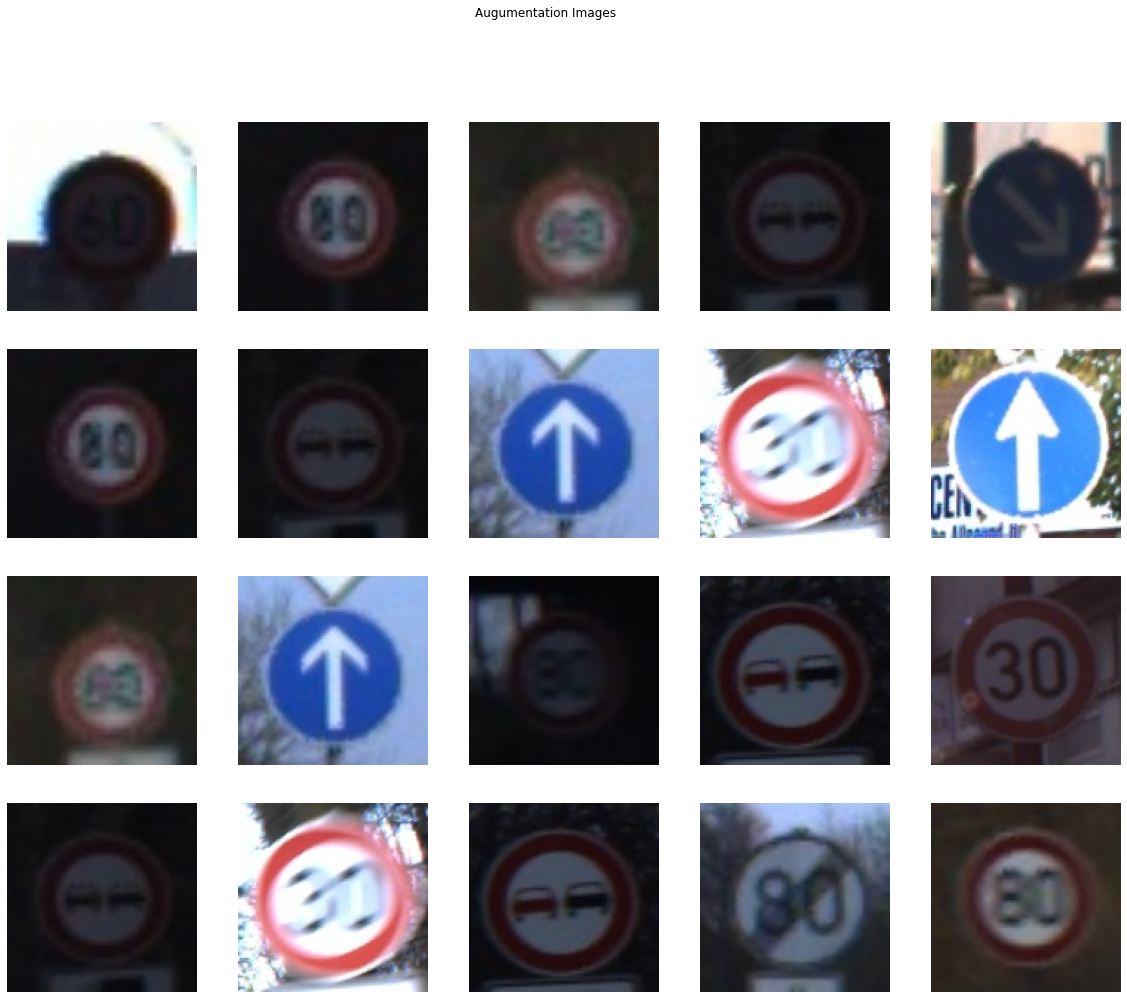

In [66]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
#Do ở trên batch_size là 20, vậy để in img trong cả batch thì ta chọn khung là 4,5
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
#Dùng đề tạo khung với kích thước 4*5 ô, rồi vẽ hình vào từng ô
#figsize khoảng cách giữa các ảnh

fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch_test[i + j + j*i]/255.0)#Tính vị trí của ảnh trong batch theo ô i,j
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))#set name cho mỗi đồ thị
    ax[i, j].axis('off')#ẩn đi trục tọa độ
plt.show()

**Main Algorithm**

Thử áp dụng Softmax Regression

In [160]:
class SoftmaxRegression:
  def __init__(self,not_trained=True,generator= None):
    self.generator=generator
    self.not_trained = True
  def softmax(self,Z):
    """
    Compute softmax values for each sets of scores in V.
    each column of V is a set of score.    
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

  def fit_batch(self, X, y, eta= .05):
    '''
      X: Đầu vào là một có shape(N,d):
        - N là số điểm dữ liệu
        - d chiều của một điểm dữ liệu
      y: là dạng one_hot_coding
    '''
    if self.not_trained:#Nếu chưa được train thì tra
      self.N = X.shape[0]
      self.d = X.shape[1]
      self.C = y.shape[1]
      self.W = np.random.randn(self.d, self.C)
      self.not_trained = False

    # mix data 
    mix_id = np.random.permutation(self.N)
    for i in mix_id:
        xi = X[i].reshape(self.d,1)
        yi = y[i].reshape(self.C,1)
        fi = np.dot(self.W.T, xi)
        ai = self.softmax(fi)

        ei = (yi - ai)
        ei = ei.reshape(self.C,1)
        self.W = self.W + eta*xi.dot(ei.T)

  def fit(self, X, y, batch_size=32, epoches=10):
    '''
    X: là Matrận data đầu vào, không cần xử lí vì đã có hàm generator
    y: là label 
    '''
    if not self.generator:
      self.generator = DataGenerator(
            all_filenames = X,
            labels = y,
            batch_size = batch_size,
            index2class = dict_labels,
            input_dim = (14, 14),
            n_channels = 3,
            n_classes = len(set_of_labels),
            normalize = True,
            zoom_range = None,
            rotation = None,
            brightness_range = None,
            shuffle = True
        )
    for i in range(0,epoches):
      for j in range(0,len(self.generator)):
        X_batch, y_batch = self.generator.__getitem__(i)
        # print(X_batch.shape)
        X_batch=X_batch.reshape(X_batch.shape[0],-1)
        # print(X_batch.shape)
        self.fit_batch(X_batch,y_batch)
      print("epoch " +str(i) + "done!")

  def pred(self, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(self.W.T.dot(X))
    return np.argmax(A, axis = 0)


In [162]:
Model = SoftmaxRegression()
Model.fit(images_train,y_label_train,epoches=3)




epoch 0done!
epoch 1done!
epoch 2done!
